In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 300
quadrature_order       = 5
nevs                   = 10        # which Eigenvector to choose
num_steps              = 200
ϵ                      = 0.003
t₀                      = 0.6      # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-9
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

145.105171 seconds (212.71 M allocations: 12.647 GiB, 1.61% gc time)


In [8]:
evs = zeros(num_steps+1,nevs)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=nevs, which=:SM);

In [9]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_flow_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ)
    DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ)
    evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

132.972441 seconds (179.54 M allocations: 10.513 GiB, 1.14% gc time)
131.497489 seconds (179.53 M allocations: 10.513 GiB, 0.91% gc time)
1/100
131.478486 seconds (170.93 M allocations: 10.091 GiB, 0.85% gc time)
129.660405 seconds (170.93 M allocations: 10.091 GiB, 0.85% gc time)
2/100
131.830893 seconds (170.93 M allocations: 10.091 GiB, 1.06% gc time)
128.007555 seconds (170.93 M allocations: 10.091 GiB, 0.81% gc time)
3/100
132.920016 seconds (170.93 M allocations: 10.091 GiB, 1.03% gc time)
127.266533 seconds (170.93 M allocations: 10.091 GiB, 0.81% gc time)
4/100
134.716418 seconds (170.93 M allocations: 10.091 GiB, 0.79% gc time)
126.987871 seconds (170.93 M allocations: 10.091 GiB, 0.80% gc time)
5/100
133.852103 seconds (170.93 M allocations: 10.091 GiB, 1.02% gc time)
125.956166 seconds (170.93 M allocations: 10.091 GiB, 0.81% gc time)
6/100
133.981882 seconds (170.93 M allocations: 10.091 GiB, 0.76% gc time)
125.545918 seconds (170.93 M allocations: 10.091 GiB, 0.82% gc time

 98.022032 seconds (170.93 M allocations: 10.091 GiB, 1.01% gc time)
57/100
164.577850 seconds (170.93 M allocations: 10.091 GiB, 0.85% gc time)
 97.624403 seconds (170.93 M allocations: 10.091 GiB, 1.03% gc time)
58/100
165.081530 seconds (170.93 M allocations: 10.091 GiB, 0.59% gc time)
 97.500905 seconds (170.93 M allocations: 10.091 GiB, 1.02% gc time)
59/100
166.297093 seconds (170.93 M allocations: 10.091 GiB, 0.83% gc time)
 96.594921 seconds (170.93 M allocations: 10.091 GiB, 1.05% gc time)
60/100
166.480006 seconds (170.93 M allocations: 10.091 GiB, 0.60% gc time)
 96.271043 seconds (170.93 M allocations: 10.091 GiB, 1.04% gc time)
61/100
166.923391 seconds (170.93 M allocations: 10.091 GiB, 0.82% gc time)
 95.389682 seconds (170.93 M allocations: 10.091 GiB, 1.07% gc time)
62/100
167.627637 seconds (170.93 M allocations: 10.091 GiB, 0.59% gc time)
 95.475944 seconds (170.93 M allocations: 10.091 GiB, 1.06% gc time)
63/100
168.246077 seconds (170.93 M allocations: 10.091 GiB, 

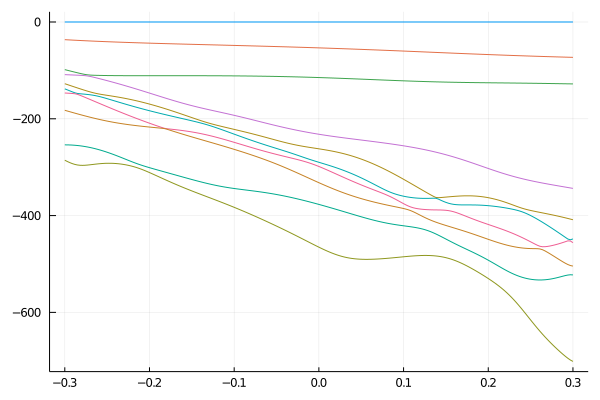

In [10]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

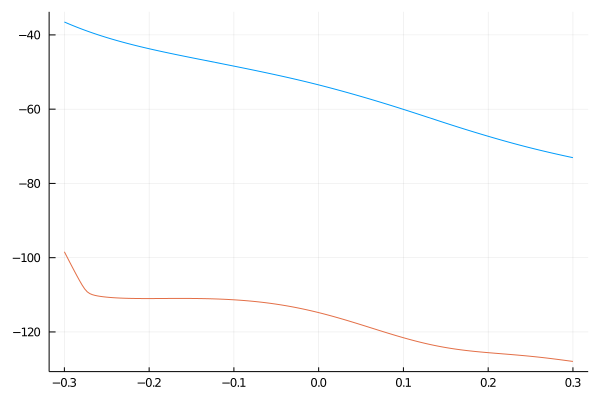

In [16]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2:3], legend=false, fmt = :png)

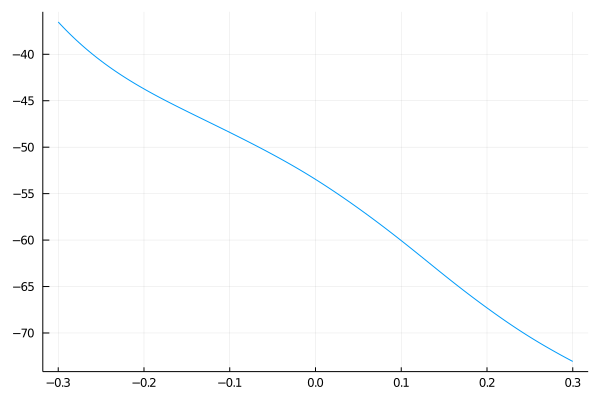

In [12]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

In [13]:
using DelimitedFiles

In [14]:
writedlm("D:/gyre_eigenvalues_n="*string(grid_resolution)*"_tol="*string(solver_tolerance)*
        "_qo="*string(quadrature_order)*"_solver="*string(solver)*"_method=CG.csv",
        [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")